In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


# DOWNLOAD FILE LIBRARY

In [2]:
!pip3 install vncorenlp
!pip install -q tf-models-official

     |████████████████████████████████| 2.7MB 28.8MB/s 
  Created wheel for vncorenlp: filename=vncorenlp-1.0.3-cp37-none-any.whl size=2645952 sha256=241a220f4d47914098ce486f5bb1d1f4afd18137c8908820b3f50c78375a7f34
  Stored in directory: /root/.cache/pip/wheels/09/54/8b/043667de6091d06a381d7745f44174504a9a4a56ecc9380c54
Successfully built vncorenlp
     |████████████████████████████████| 1.6MB 33.7MB/s 
     |████████████████████████████████| 358kB 55.7MB/s 
     |████████████████████████████████| 645kB 51.8MB/s 
     |████████████████████████████████| 215kB 59.3MB/s 
     |████████████████████████████████| 102kB 12.3MB/s 
     |████████████████████████████████| 686kB 42.4MB/s 
     |████████████████████████████████| 38.2MB 78kB/s 
     |████████████████████████████████| 51kB 8.7MB/s 
     |████████████████████████████████| 1.2MB 52.7MB/s 
     |████████████████████████████████| 61kB 9.4MB/s 


In [3]:
# !Download VnCoreNLP-1.1.1.jar & its word segmentation component (i.e. RDRSegmenter) 
# !mkdir -p vncorenlp/models/wordsegmenter
# !wget https://raw.githubusercontent.com/vncorenlp/VnCoreNLP/master/VnCoreNLP-1.1.1.jar
# !wget https://raw.githubusercontent.com/vncorenlp/VnCoreNLP/master/models/wordsegmenter/vi-vocab
# !wget https://raw.githubusercontent.com/vncorenlp/VnCoreNLP/master/models/wordsegmenter/wordsegmenter.rdr
# !mv VnCoreNLP-1.1.1.jar vncorenlp/ 
# !mv vi-vocab vncorenlp/models/wordsegmenter/
# !mv wordsegmenter.rdr vncorenlp/models/wordsegmenter/

# !mkdir -p pho2vec
# !wget https://public.vinai.io/word2vec_vi_words_300dims.zip
# !mv word2vec_vi_words_300dims.zip pho2vec/
# !unzip "./pho2vec/word2vec_vi_words_300dims.zip"

# IMPORT LIBRARY AND PATH DATASET

In [4]:
import pandas as pd
import numpy as np
import os
from vncorenlp import VnCoreNLP
import numpy as np
import pickle
import matplotlib.pyplot as plt
import warnings
import logging

from gensim.test.utils import datapath, get_tmpfile
from gensim.models import KeyedVectors

import tensorflow as tf
# from transformers import TFAutoModel
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Dropout, Dense, Embedding, LSTM, Bidirectional, GRU, TimeDistributed, Flatten
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import matthews_corrcoef, confusion_matrix
from sklearn import metrics
from sklearn.utils import shuffle
from official.nlp import optimization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.train import CheckpointOptions

np.random.seed(7)

In [5]:
path_root = '/content/drive/MyDrive/KTDLTT'
path_img = os.path.join(path_root, 'model/VSMEC/BiLSTM/images')
MODEL_PATH = os.path.join(path_root, 'model/VSMEC/BiLSTM')
name_model = 'VSMEC_BiLSTM'

path_VSMEC_train = os.path.join(path_root, 'data/UIT-VSMEC/train_nor_811.xlsx')
path_VSMEC_test = os.path.join(path_root, 'data/UIT-VSMEC/test_nor_811.xlsx')
path_VSMEC_dev = os.path.join(path_root, 'data/UIT-VSMEC/valid_nor_811.xlsx')

# DATA LOADER AND PREPROCESSING

In [6]:
df_train = pd.read_excel(path_VSMEC_train).iloc[:,1:]
df_test = pd.read_excel(path_VSMEC_test).iloc[:,1:]
df_dev = pd.read_excel(path_VSMEC_dev).iloc[:,1:]

In [7]:
annotator = VnCoreNLP(os.path.join(path_root, "src/vncorenlp/VnCoreNLP-1.1.1.jar"), annotators="wseg", max_heap_size='-Xmx500m') 

def preprocessing(row):
  def tokenizer(row):
    row = annotator.tokenize(row)
    return ' '.join([' '.join(words) for words in row])
  return tokenizer(row)

In [8]:
df_train.loc[:, 'Sentence'] = df_train.loc[:, 'Sentence'].apply(preprocessing)
df_test.loc[:, 'Sentence'] = df_test.loc[:, 'Sentence'].apply(preprocessing)
df_dev.loc[:, 'Sentence'] = df_dev.loc[:, 'Sentence'].apply(preprocessing)

In [9]:
df_train.head(5)

,Emotion,Sentence
0,Other,cho mình xin bài nhạc tên là gì với ạ
1,Disgust,cho đáng_đời con quỷ . về nhà lôi con nhà mày ...
2,Disgust,lo học đi . yêu_đương lol gì hay lại thích học...
3,Enjoyment,uớc gì sau_này về già vẫn có_thể như cụ này : ) )
4,Enjoyment,mỗi lần có video của con là cứ coi đi coi lại ...


In [10]:
# Load Pho2wv
# pho2wv = KeyedVectors.load_word2vec_format(os.path.join(path_root, 'src/word2vec_vi_words_300dims.txt'))

In [11]:
MAX_NB_WORDS = 75000
MAX_SEQUENCE_LENGTH = 128
DROPOUT = 0.5
nclasses = len(df_train['Emotion'].unique())
EMBEDDING_DIM = 300
BATCH_SIZE = 50
EPOCH = 10
lr = 1e-2
STEPS_PER_EPOCH = len(df_train['Sentence']) // BATCH_SIZE
VALIDATION_STEPS = len(df_dev['Sentence']) // BATCH_SIZE

In [12]:
tokenizer = Tokenizer(num_words=MAX_NB_WORDS, oov_token='<OOV>')
tokenizer.fit_on_texts(df_train['Sentence'])
word_index = tokenizer.word_index

In [13]:
def prepare_input(sents, tokenizer, MAX_SEQUENCE_LENGTH=MAX_SEQUENCE_LENGTH):
  sequences = tokenizer.texts_to_sequences(sents)
  sents = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH, truncating='post', padding='post')
  return sents

In [14]:
labels = {emo:id_  for id_, emo in enumerate(list(df_train['Emotion'].unique()))}
def label_encoder(row):
  row = labels[row]
  return row

In [15]:
df_dev 

,Emotion,Sentence
0,Other,"tính tao tao biết , chẳng có chuyện gì có_thể ..."
1,Enjoyment,"lại là lào_cai , tự_hào quê mình quá : ) )"
2,Sadness,bị từ_chối rồi
3,Enjoyment,tam_đảo trời đẹp các mem à
4,Other,đọc bình_luận của thằng đó không thiếu chữ nào 😂😂
...,...,...
681,Sadness,nhọc_lòng : ( ( (
682,Sadness,tao đã rất muốn làm_bạn tốt anh_em tri_kỉ với ...
683,Disgust,cơm tấm ở ngoài cũng như này . 😡
684,Surprise,chất_liệu đỉnh quá


In [16]:
X_train = prepare_input(df_train['Sentence'], tokenizer)
Y_train = np.array(df_train['Emotion'].apply(label_encoder).tolist())

X_dev = prepare_input(df_dev['Sentence'], tokenizer)
Y_dev = np.array(df_dev['Emotion'].apply(label_encoder).tolist())

In [17]:
# # Create embedding matrix 
# def create_embedding(EMBEDDING_DIM, word_index, embedding_dict):
#   embedding_matrix = np.random.random((len(word_index) + 1, EMBEDDING_DIM))
#   for word, i in word_index.items():
#     try:
#       embedding_vector = embedding_dict.get_vector(word)
#     except:
#       embedding_vector = None
#     if embedding_vector is not None:
#       if len(embedding_matrix[i]) != len(embedding_vector):
#         # words not found in embedding index will be all-zeros.
#           if len(embedding_matrix[i]) != len(embedding_vector):
#             print("could not broadcast input array from shape", str(len(embedding_matrix[i])),
#                   "into shape", str(len(embedding_vector)), " Please make sure your"
#                                                             " EMBEDDING_DIM is equal to embedding_vector file ,GloVe,")
#             exit(1)
#           embedding_matrix[i] = embedding_vector
#   return embedding_matrix
# embedding_matrix = create_embedding(EMBEDDING_DIM, word_index, embedding_dict=pho2wv)
# np.save(os.path.join(path_root, 'data/vector/pho2wv_VSMEC.npy'), embedding_matrix)

In [18]:
# Load embedding matrix from file npy
embedding_matrix = np.load(os.path.join(path_root, 'data/vector/pho2wv_VSMEC.npy'))

# Fine-tuning with TensorFlow

## Define the model

In [19]:
def create_model(word_index, embedding_matrix, optimizer, nclasses=nclasses, MAX_SEQUENCE_LENGTH=MAX_SEQUENCE_LENGTH, EMBEDDING_DIM=EMBEDDING_DIM, dropout=DROPOUT, lstm_node=32):
  model = Sequential()
  
  model.add(Embedding(len(word_index) + 1,
                      EMBEDDING_DIM,
                      weights=[embedding_matrix],
                      input_length=MAX_SEQUENCE_LENGTH,
                      trainable=True))
  
  model.add(Bidirectional(LSTM(lstm_node, return_sequences=True)))
  model.add(Bidirectional(LSTM(lstm_node)))
  model.add(Dropout(dropout))
  
  model.add(Dense(nclasses, activation='softmax'))

  model.compile(loss='sparse_categorical_crossentropy',
                      optimizer=optimizer,
                      metrics=['accuracy'])
  return model

## Optimizer

In [20]:
optimizer = 'adam'

## Callbacks

In [21]:
early_stop_callback = EarlyStopping(monitor='val_loss', patience=5, verbose=1)

checkpoint_path = MODEL_PATH + '/checkpoints/cp-{epoch:03d}.ckpt'
# checkpoint_dir = os.path.dirname(checkpoint_path)

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath = checkpoint_path, 
    save_weights_only = True,
    save_freq = 10 * STEPS_PER_EPOCH, 
    verbose = 1
)

## Training

In [22]:
model = create_model(word_index, embedding_matrix, optimizer, nclasses, MAX_SEQUENCE_LENGTH, EMBEDDING_DIM, DROPOUT, 128)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 128, 300)          1319700   
_________________________________________________________________
bidirectional (Bidirectional (None, 128, 256)          439296    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 256)               394240    
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense (Dense)                (None, 7)                 1799      
Total params: 2,155,035
Trainable params: 2,155,035
Non-trainable params: 0
_________________________________________________________________


In [23]:
history = model.fit(X_train, Y_train,
                              validation_data=(X_dev, Y_dev),
                              epochs=EPOCH,
                              batch_size=BATCH_SIZE,
                              callbacks = [
                                  early_stop_callback, 
                                  checkpoint_callback
                              ],
                              verbose=1)

Epoch 1/10
111/111 [==============================] - 17s 57ms/step - loss: 1.8181 - accuracy: 0.2559 - val_loss: 1.7368 - val_accuracy: 0.3294
Epoch 2/10
111/111 [==============================] - 5s 46ms/step - loss: 1.7097 - accuracy: 0.3293 - val_loss: 1.6341 - val_accuracy: 0.3688
Epoch 3/10
111/111 [==============================] - 5s 46ms/step - loss: 1.5854 - accuracy: 0.3866 - val_loss: 1.5736 - val_accuracy: 0.3907
Epoch 4/10
111/111 [==============================] - 5s 46ms/step - loss: 1.4688 - accuracy: 0.4306 - val_loss: 1.5306 - val_accuracy: 0.4067
Epoch 5/10
111/111 [==============================] - 5s 46ms/step - loss: 1.3486 - accuracy: 0.4872 - val_loss: 1.5341 - val_accuracy: 0.4140
Epoch 6/10
111/111 [==============================] - 5s 46ms/step - loss: 1.2077 - accuracy: 0.5523 - val_loss: 1.4320 - val_accuracy: 0.4679
Epoch 7/10
111/111 [==============================] - 5s 46ms/step - loss: 1.0897 - accuracy: 0.6002 - val_loss: 1.4699 - val_accuracy: 0.463

# Predict on test data

In [24]:
X_test = prepare_input(df_test['Sentence'], tokenizer)
y_test = np.array(df_test['Emotion'].apply(label_encoder).tolist())

In [25]:
print("\n Evaluating Model ... \n")
y_pred = model.predict(X_test, batch_size=BATCH_SIZE, verbose=1).argmax(axis=-1)
metric = metrics.classification_report(y_test, y_pred, output_dict=True)
print(metrics.classification_report(y_test, y_pred, target_names=labels, digits=4))


 Evaluating Model ... 

14/14 [==============================] - 1s 15ms/step
              precision    recall  f1-score   support

       Other     0.3894    0.3411    0.3636       129
     Disgust     0.3991    0.6894    0.5056       132
   Enjoyment     0.6409    0.6010    0.6203       193
       Anger     0.0000    0.0000    0.0000        40
    Surprise     0.4706    0.2162    0.2963        37
     Sadness     0.6111    0.5690    0.5893       116
        Fear     0.5116    0.4783    0.4944        46

    accuracy                         0.5007       693
   macro avg     0.4318    0.4136    0.4099       693
weighted avg     0.4884    0.5007    0.4840       693



In [26]:
f1 = round(metric['macro avg']['f1-score'], 4)
name_model = name_model + '_' + str(lr).replace('.', '') + '_' + str(MAX_SEQUENCE_LENGTH) + '_' + str(BATCH_SIZE) + '_' + str(DROPOUT).replace('.', '') + '_' + str(f1).replace('.', '') + '.h5'
name_img_ = 'loss' + '_' + str(lr).replace('.', '') + '_' + str(MAX_SEQUENCE_LENGTH) + '_' + str(BATCH_SIZE) + '_' + str(DROPOUT).replace('.', '') + '_' + str(f1).replace('.', '') + '.png'
model.save_weights(os.path.join(MODEL_PATH, name_model))

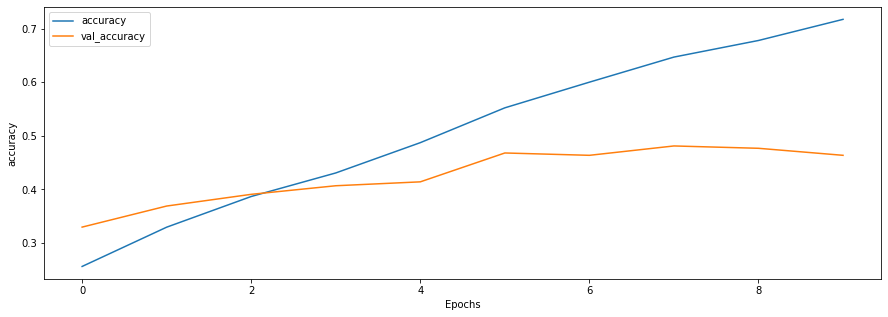

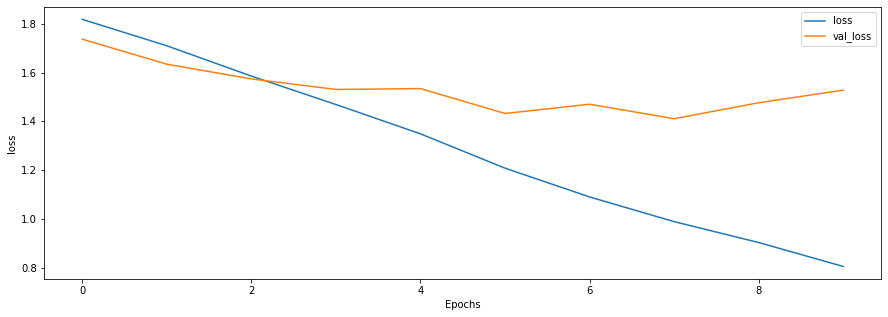

In [27]:
def plot_graphs(history, string):
  fig = plt.figure(figsize=(15, 5))
  name_img = string + '_' + str(lr).replace('.', '') + '_' + str(MAX_SEQUENCE_LENGTH) + '_' + str(BATCH_SIZE) + '_' + str(DROPOUT).replace('.', '') + '_' + str(f1).replace('.', '') + '.png'
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string], '')
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  fig.savefig(os.path.join(path_img, name_img), bbox_inches='tight') 
  plt.show()

plot_graphs(history, 'accuracy')
plot_graphs(history, 'loss')

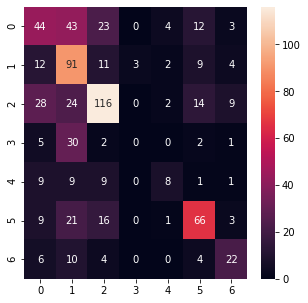

In [28]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

def _confusion_matrix(Y_test, y_pred, metric, name_model, path_img=path_img):
  f1 = round(metric['macro avg']['f1-score'], 4)
  name_img = 'CM_' + name_model + '_' + str(f1).replace('.', '') + '.png' 
  cf_matrix = confusion_matrix(Y_test, y_pred)
  fig = plt.figure(figsize=(5, 5))
  sns.heatmap(cf_matrix, annot=True, fmt='g')
  sns.set(font_scale=1)
  fig.savefig(os.path.join(path_img, name_img), bbox_inches='tight')
  plt.show()

_confusion_matrix(y_test, y_pred, metric, name_model)